<a href="https://colab.research.google.com/github/galwiner/ColdLabControl/blob/master/g2_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  # g2 calculation in pulse sequences: an introduction

 ---

  $g^2(\tau)$ is a measure of intensity cross correlation where $\tau$ is some time difference between two detectors. It is particularly important in Qunatum Optics (QO), where it can take values not allowed within the classical treatment of light, exposing the Quantum nature of suitable states.

  $g^2(\tau)$ is measured in a variery of QO experiments, often as a proof that single quanta of light are emitted from sources such as quantum dots, parametric down conversion or cascade phenomena in atomic vapor.

 In cold atom experiments, an atomic cloud is prepared and then trapped in a dipole trap. By repeatedly flashing the dipole trap laser, it is possible to release and recapture the cloud, performing a single experimental cycle during each release. During the "experiment" phase, the probe light is turned on and picked up by a number of Single Photon Counting Modules (SPCM), typically in a Hanbury Brown Twiss (HBT) configuration. The resulting photon arrival times are recorded by a Time-Tagger, a device which is able to record the SPCM detection signals with ps resolution.

 To calculate $g^2(\tau)$, we must be able to collect a set of time stamps from the time-tagger channels connected to the SPCMs and reference each of their time signal to t=0 of that pulse (which has duration $T_{pulse}$. We then calculate the normalized cross correlation as follows:

  $$$g^2(t1,t2) = \frac{<n_1(t_1)n_2(t_2)>}{<n_1(t1)><n_2(t2)>}$$

  This is a two-coordinate measure, where each detector has its own time and we are not yet measuring a time diffrenece. We will now explain the averaging step involving each term in the expression above.

  $<n_i(t_i)>$ is a histogram of arrival times collected in the $i^{th}$ detector averaged over the ensemble of pulses. Averaginging over sufficiently large ensembles, this reveals the temporal shape of the pulse.

In [4]:
!pip install fast_histogram
import numpy as np
import random
import matplotlib.pyplot as plt
from fast_histogram import histogram1d
import warnings
# numPulses = 1000
# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('text', usetex=True)

# to flatten lists of lists


def flatten(l): return [item for sublist in l for item in sublist]


def makePhotonCountMat(numPulses=100, pulseDuration=10000, meanPhotonPerPulse=2, pulseShape='gauss'):
    pulses = []
    for pulse in range(numPulses):
        photonsInBunch = np.random.poisson(meanPhotonPerPulse)
        if pulseShape == 'rect':
            times = random.sample(range(pulseDuration), photonsInBunch)
            times.sort()
            pulses.append(times)
        elif pulseShape == 'gauss':
            times = np.random.normal(
                pulseDuration/2, pulseDuration/8, size=photonsInBunch)
#             times.sort()
            pulses.append(times)

    return pulses


def meanPerPulse(det, bins=10, pulseDuration=10000):
    pulseNum=len(det)
#     binWidth=pulseDuration/bins
    dat = histogram1d(flatten(det), bins=bins, range=[0, pulseDuration])/pulseNum
    binCents = np.linspace(0, pulseDuration, bins)
    return dat, binCents


 ## Generating test data and calculating $<n_i(t_i)>$


 ---

 The function ```makePhotonCountMat(numPulses, pulseDuration,pulseShape)``` generates a list of lists, where each sublist containes  photon arrival times. The times in sublists are already referenced to the begining of the pulse and are less than the pulse duration. numPulses sets the number of sublists. I've implemented either a rectangular or a gaussian shape to the pusle, though the Gaussian currently has a fixed mean and variance (=1/4 of the pulse duration)

 To calculate  $<n_i(t_i)>$, we un



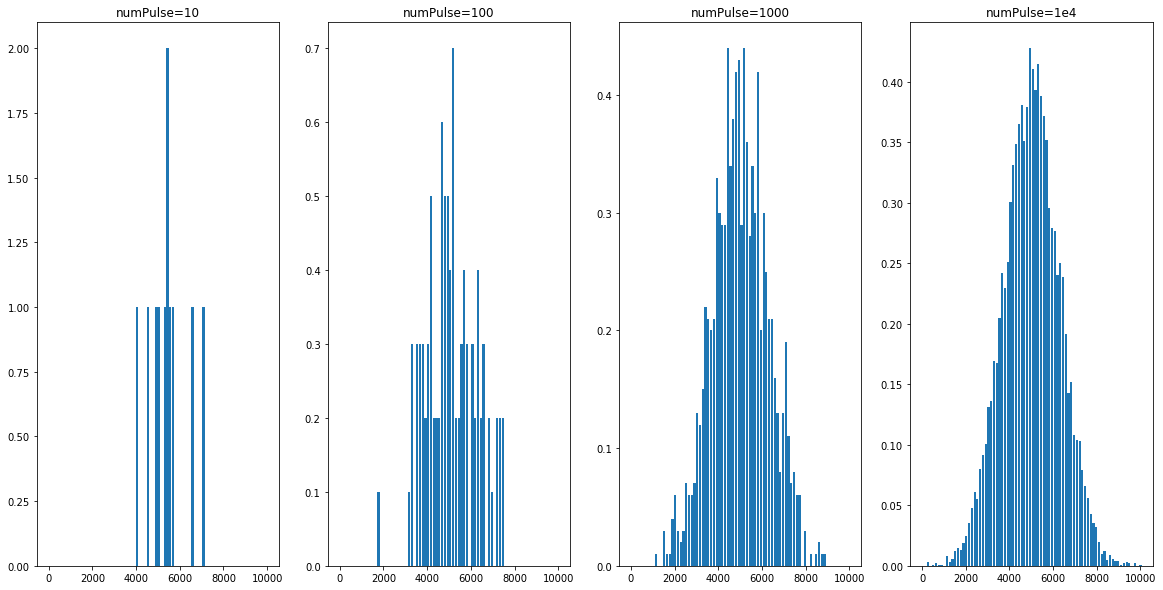

In [5]:
num = 1000
pulseDuration = 10000
bins = 80
photonsPerPulse=10
pulseShape='gauss'
det1 = makePhotonCountMat(
    numPulses=num, pulseShape=pulseShape, pulseDuration=pulseDuration,meanPhotonPerPulse=photonsPerPulse)
det2 = makePhotonCountMat(numPulses=int(
    num/1000), pulseShape=pulseShape, pulseDuration=pulseDuration,meanPhotonPerPulse=photonsPerPulse)
det3 = makePhotonCountMat(numPulses=int(
    num/100), pulseShape=pulseShape, pulseDuration=pulseDuration,meanPhotonPerPulse=photonsPerPulse)
det4 = makePhotonCountMat(numPulses=int(
    num/10), pulseShape=pulseShape, pulseDuration=pulseDuration,meanPhotonPerPulse=photonsPerPulse)
n1t1 = meanPerPulse(det1, bins=bins)
n2t2 = meanPerPulse(det2, bins=bins)
n3t3 = meanPerPulse(det3, bins=bins)
n4t4 = meanPerPulse(det4, bins=bins)
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.bar(n2t2[1], n2t2[0], width=0.8*pulseDuration/bins)
# plt.ylim([0,1])
plt.title('numPulse=10');
plt.subplot(1, 4, 2)
plt.bar(n3t3[1], n3t3[0], width=0.8*pulseDuration/bins)
# plt.ylim([0,1])
plt.title('numPulse=100');
plt.subplot(1, 4, 3)
plt.bar(n4t4[1], n4t4[0], width=0.8*pulseDuration/bins)
# plt.ylim([0,1])
plt.title('numPulse=1000');
plt.subplot(1, 4, 4)
plt.bar(n1t1[1], n1t1[0], width=0.8*pulseDuration/bins)
# plt.ylim([0,1])
plt.title('numPulse=1e4');


 #calculating the bivariate distribution <n_1(t_1)><n_2(t_2)>

 Now that we have the single detector distributions, we can calculate the bivariate distribution by calculating the outer prodect of the two distributions. This gives us a two dimensional map

Text(0.5, 0, 't2')

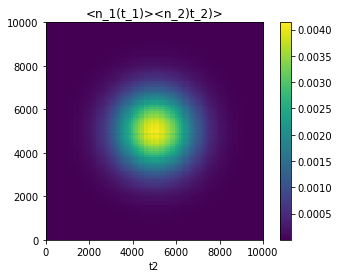

In [6]:


def biVariateMeanPerPulse(det1, det2, bins=bins):
    # calculates <n1(t1)><n2(t2)>
    hist1, binedges1 = meanPerPulse(det1, bins=bins)
    hist2, binedges2 = meanPerPulse(det2, bins=bins)
    return np.outer(hist1, hist2), binedges1, binedges2


num = 100000
det1 = makePhotonCountMat(
    numPulses=num, pulseShape='gauss', pulseDuration=pulseDuration)
det2 = makePhotonCountMat(
    numPulses=num, pulseShape='gauss', pulseDuration=pulseDuration)


biVar1 = biVariateMeanPerPulse(det1, det2, bins=100)[0]
plt.imshow(biVar1, extent=[0, pulseDuration, 0, pulseDuration], origin='lower')
plt.colorbar()
plt.title('<n_1(t_1)><n_2)t_2)>')
plt.xlabel('t1')
plt.xlabel('t2')


 # calculating the joint bivariate distribution <n_1(t_1)n_2(t_2)>

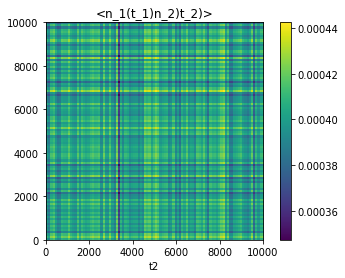

In [7]:


def biVariateCorrelation(det1, det2, pulseDuration=10000, bins=10):
    # calculate <n1(t1)n2(t2)>
    #     [np.histogram(k, range=(0, pulseDuration))[0] for k in det1]
    #     [np.histogram(k, range=(0, pulseDuration))[0] for k in det2]
    def acuumulate(row1, row2):
        return np.outer(histogram1d(row1, bins=bins, range=(0, pulseDuration)), histogram1d(row2, bins=bins, range=(0, pulseDuration)))

    subtotal = np.zeros((bins, bins))
    for idx, row in enumerate(det1):
        subtotal += acuumulate(det1[idx], det2[idx])
    # dat = [np.outer(histogram1d(k, bins=bins, range=(0, pulseDuration)), histogram1d(
        # l, bins=bins, range=(0, pulseDuration))) for k in det1 for l in det2]
    return subtotal/len(det1)


num = 100000
bins = 100
photonsPerPulse=2
det1 = makePhotonCountMat(
    numPulses=num, pulseShape='rect', pulseDuration=pulseDuration,meanPhotonPerPulse=photonsPerPulse)
det2 = makePhotonCountMat(
    numPulses=num, pulseShape='rect', pulseDuration=pulseDuration,meanPhotonPerPulse=photonsPerPulse)
jointBiVar = biVariateCorrelation(det1, det2, bins=bins)
biVar,t1cents,t2cents=biVariateMeanPerPulse(det1,det2,bins=bins)
plt.imshow(biVar, extent=[0, pulseDuration, 0, pulseDuration], origin='lower')
plt.title('<n_1(t_1)n_2)t_2)>')
plt.colorbar()
plt.xlabel('t1');
plt.xlabel('t2');


 # Normalizing g2(t_1,t_2)

Divinding the joint probability distribution by the inidividual distributions gives us g2(t1,t2). 
we deal with cases of division by 0, by setting them to 1 manually. 


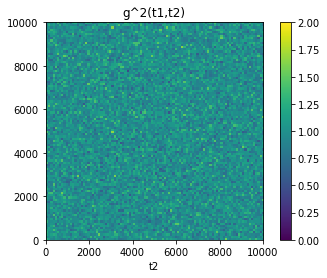

In [8]:
def g2norm(jointBiVar,biVar):
    #jointBiVar=<n1(t1)n2(t2)>
    #biVar=<n1(t1)><n2(t2)>
    jointBiVar[biVar==0]=1 #to deal with 0/0 
    biVar[biVar==0]=1
    normed=jointBiVar/biVar
    return normed
g2t1t2=g2norm(jointBiVar,biVar)
plt.imshow(g2t1t2,extent=[0, pulseDuration, 0, pulseDuration],origin='lower')
plt.colorbar()
plt.clim([0, 2])
plt.title('g^2(t1,t2)');
plt.xlabel('t1');
plt.xlabel('t2');


 # Dealing with numerical noise

 Looking at the matrix above, there is clearly an issue around the periphery of the cross corrleation.
 This is due to division by small values around the edges of the gaussian pulse in this case.
 We'll deal with this by finiding an ROI where the variance is less than maxVar. 
 if an ROI is not found, the whole matrix is returned and a warning is displayed. 

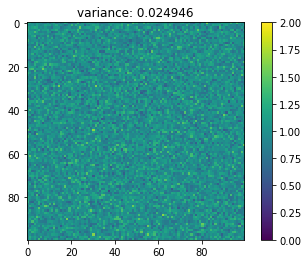

In [9]:

def getMatrixROI(data, maxVar=0.1):
    data_size = np.shape(data)
    var = np.nanvar(data)
    start = 0
    stop = data_size[1]
    while var > maxVar:
        if start==stop:
            warnings.warn("ROI Not found", UserWarning)
            return np.s_[0:data_size[1],0:data_size[1]]
        else:
            var = np.nanvar(data[start:stop, start:stop])
            start += 1
            stop -= 1
    return np.s_[start:stop, start:stop]


ROI = getMatrixROI(g2t1t2, maxVar=0.03)

plt.imshow(g2t1t2[ROI])
# plt.imshow(g2t1t2)
plt.clim([0, 2])
plt.colorbar()
plt.title("variance: {:f}".format(np.nanvar(g2t1t2[ROI])));

 # switching to reltaive time coordinate $\tau$

 this is done by summing over anti-diagonal. Note that this is true because time is constant on each anti-diagonal (this is also how the function works). 
 NOTE: I am not fully conviced why this is the case. and we have edge effects which need to be corrected. 

Text(0, 0.5, 'g2')

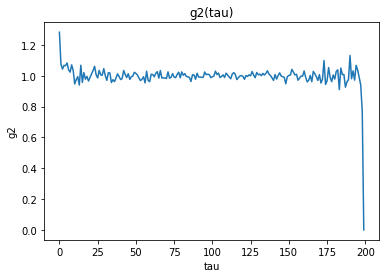

In [10]:

def avgAntiDiagonal(data):
    # move to a relative time coordinate by averaging over the anti diagonal of the matrix
    # go over coordinate pairs whos sum is somewhere in this range
    sums = range(2*len(data))
    ind = range(len(data))
    coords = [(s, [k, t]) for k in ind for t in ind
              for s in sums if k+t == s]
    coords.sort()
    diag = np.zeros(2*len(data))
    for s in sums:
        idx = [k[1] for k in coords if k[0] == s]
        if idx == []:
            break
        for pos, id in enumerate(idx):

            i, j = id
            diag[s] += data[i, j]
        diag[s] = diag[s]/len(idx)
    return diag


plt.plot(avgAntiDiagonal(g2t1t2[ROI]));
plt.title('g2(tau)');
plt.xlabel('tau');
plt.ylabel('g2')



 # combine everything to a single g2(tau) function


In [0]:
num = 100000
bins = 100
pulseDuration = 10000
det1 = makePhotonCountMat(
    numPulses=num, pulseShape='gauss', pulseDuration=pulseDuration)
det2 = makePhotonCountMat(
    numPulses=num, pulseShape='gauss', pulseDuration=pulseDuration)


def g2tau(det1, det2, bins=100, maxVar=0.01):
    jointBiVar = biVariateCorrelation(det1, det2, bins=bins) #<n1(t1)n2(t2)>
    biVar = biVariateMeanPerPulse(det1, det2, bins=bins)[0] #<n1(t1)><n2(t2)>
    g2t1t2 =g2norm(jointBiVar,biVar) 
    ROI = getMatrixROI(g2t1t2, maxVar)
#     divg2_norm = divg2[ROI]/np.mean(divg2[ROI])
#     return avgAntiDiagonal(g2t1t2[ROI]
#     return avgAntiDiagonal(g2t1t2)
    return g2t1t2[ROI]

# plt.plot(g2tau(det1, det2, maxVar=0.01))



## generating correlated data
we now want to see correlations in the data by breaking the poissonian distribution

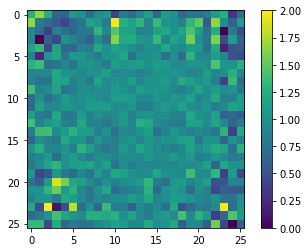

In [12]:
def distributePhotons(photonNum):
        numInDet1=np.random.binomial(photonNum,bsBias)
        return (numInDet1,photonNum-numInDet1)

def makeCorrelatedData(numPulses=10,pulseShape='gauss',pulseDuration=10000,meanPhotonsPerPulse=100,bsBias=0.5,bins=100):
    det=makePhotonCountMat(numPulses, pulseDuration, meanPhotonsPerPulse, pulseShape)
    pulses0=[] #first detector
    pulses1=[] #second detector
    for row in det:
        histDat=histogram1d(row,bins=bins, range=(0, pulseDuration))
        binCents=(np.linspace(0,pulseDuration,bins)+0.5*pulseDuration/bins).tolist()
        times0=[]
        times1=[]
#         print(histDat)
        for idx,val in enumerate(histDat):  
            photonsInDet0=int(np.random.binomial(val,bsBias))
            photonsInDet1=int(val-photonsInDet0)
            times0.extend([binCents[idx]]*photonsInDet0)
            times1.extend([binCents[idx]]*photonsInDet1)
# #             if detNum==0:
# #                 times0.append(time)
# #             else:
# #                 times1.append(time)
        pulses0.append(times0)
        pulses1.append(times1)
    return pulses0,pulses1

det1,det2=makeCorrelatedData()
dat=g2tau(det1, det2, maxVar=0.1,bins=50)
plt.imshow(dat)
plt.clim([0,2])
plt.colorbar()
# dat

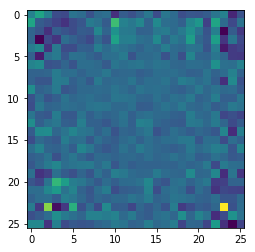

In [13]:
plt.imshow(dat)

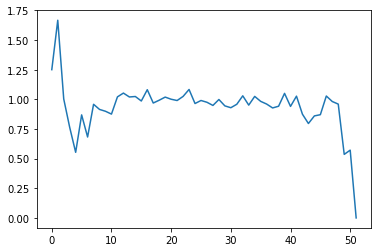

In [14]:
plt.plot(avgAntiDiagonal(dat))

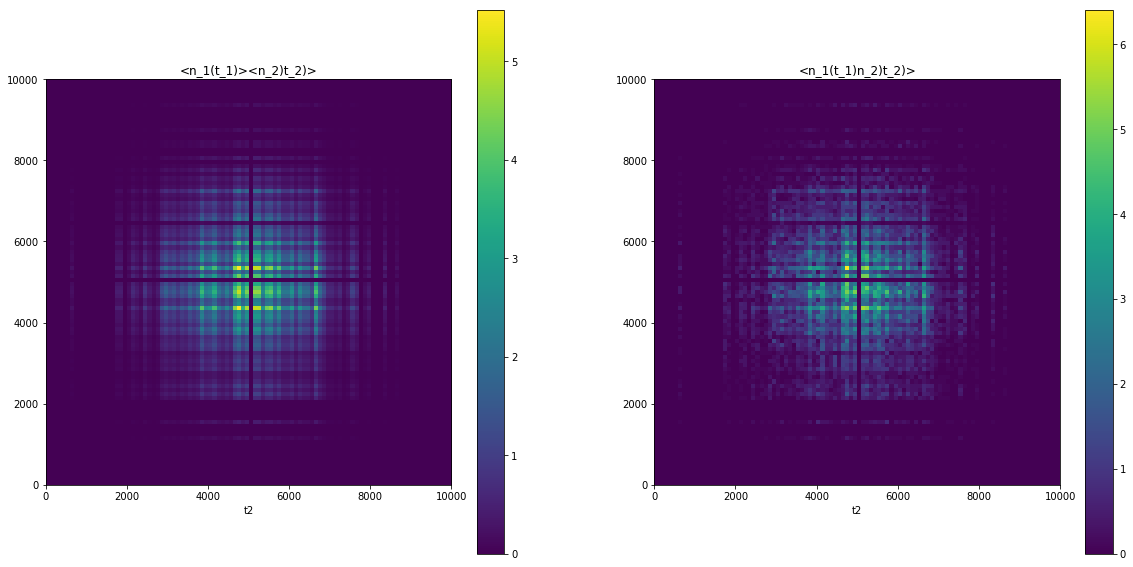

In [15]:
jointBiVar = biVariateCorrelation(det1, det2, bins=bins)
biVar,t1cents,t2cents=biVariateMeanPerPulse(det1,det2,bins=bins)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(biVar, extent=[0, pulseDuration, 0, pulseDuration], origin='lower')
plt.title('<n_1(t_1)><n_2)t_2)>')
plt.colorbar()
plt.xlabel('t1');
plt.xlabel('t2');
plt.subplot(1,2,2)
plt.imshow(jointBiVar, extent=[0, pulseDuration, 0, pulseDuration], origin='lower')
plt.title('<n_1(t_1)n_2)t_2)>')
plt.colorbar()
plt.xlabel('t1');
plt.xlabel('t2');

In [16]:
np.shape(np.outer(histogram1d(det1[1],bins=100,range=[0,10000]),histogram1d(det1[1],bins=100,range=[0,10000])))

(100, 100)